In [1]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Conv2D, LeakyReLU, Conv2DTranspose, Flatten, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds

In [2]:
def build_generator(img_size, latent_dim):
    z = Input(latent_dim)
    x = tf.keras.layers.Reshape((4, 4, -1))(z)
    
    x = Conv2DTranspose(512, (5, 5), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(512, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(256, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(128, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(img_size[-1], (5,5),strides=(2,2),padding="same", activation = tf.nn.leaky_relu)(x)
    return Model(z, x)

def build_encoder(img_size, latent_dim):
    x = Input(img_size)
    
    y = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    y = Conv2D(128, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    
    y = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    
    y = Conv2D(512, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    
    y = Conv2D(1024, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(1024, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    
    y = Flatten()(y)
    y = Dense(latent_dim)(y)
    return Model(x,y)

def build_discriminator(img_size, latent_dim):
    x = Input(img_size)
    z = Input(latent_dim)
    _z = Flatten()(z)
    _z = Dense(img_size[0]*img_size[1]*img_size[2])(_z)
    _z = Reshape(img_size)(_z)

    y = Concatenate()([x,_z])
    y = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(128, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(1024, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(1024, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Flatten()(y)
    y = Dense(1)(y)
    return Model([x, z], [y])



In [3]:
def load_dataset(data_dir, img_size = 64, batch_size = 1):
    df = tf.keras.utils.image_dataset_from_directory(directory = data_dir, 
                                                     labels = None, 
                                                     batch_size= None,
                                                     image_size = (img_size, img_size),
                                                     seed = 42)
    
    return df

In [4]:
data_folder = "sample_data/"
img_dim = 64
train_ds = load_dataset(data_folder+"img", img_size = img_dim, batch_size = 1)

Found 2560 files belonging to 1 classes.


2023-03-26 05:41:31.561494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 05:41:31.614233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 05:41:31.617926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 05:41:31.633989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
def apply_norm(x):
    return (x*2)/255.0 - 1

In [6]:
latent_dim = 256
img_size = (img_dim, img_dim, 3)

enc = build_encoder(img_size, latent_dim)
gen = build_generator(img_size, latent_dim)
disc = build_discriminator(img_size, latent_dim)

g_opt = Adam(learning_rate = 1e-4)
e_opt = Adam(learning_rate = 1e-4)
d_opt = Adam(learning_rate = 1e-4)

In [7]:
num = len(train_ds)
train_ds = tfds.as_numpy(train_ds.map(apply_norm))

In [8]:
epochs = 10
batch_size = 32

In [9]:
X_train = np.array([i for i in train_ds])
X_train = X_train.reshape(-1, batch_size, img_dim, img_dim, 3)

In [10]:
loss = []
d_steps_per_iter = 1
steps_per_iter = 5

for epoch in tqdm(range(epochs), desc='Total'):
    running_loss = [0,0,0]
    num_steps = num//batch_size
    np.random.shuffle(X_train)
    
    for steps in range(0, num_steps):
        x_batch = X_train[steps]

        disc_loss_ = []
        for steps in range(d_steps_per_iter):
            z_batch = np.random.normal(scale = 2, size = (batch_size, latent_dim)).astype("float32")
            with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:      
                fake_img = gen(z_batch)
                fake_z = enc(x_batch)

                preds = disc([tf.concat([fake_img, x_batch], axis = 0) , tf.concat([z_batch, fake_z], axis = 0)])
                pred_gen, pred_enc = tf.split(preds, 2, axis = 0)
                disc_loss = tf.reduce_mean(tf.nn.softplus(pred_gen)) + tf.reduce_mean(tf.nn.softplus(-pred_enc))
                
            disc_grad = tape.gradient(disc_loss, disc.trainable_variables)
            d_opt.apply_gradients(zip(disc_grad,disc.trainable_variables))
                
            disc_loss_.append(disc_loss.numpy())
            
            del disc_grad
            del tape
            
        running_loss[0] += sum(disc_loss_)/steps_per_iter
        
        gen_loss_ = []
        enc_loss_ = []
        for steps in range(steps_per_iter):
            z_batch = np.random.normal(scale = 2, size = (batch_size, latent_dim)).astype("float32")
            with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:      
                fake_img = gen(z_batch)
                fake_z = enc(x_batch)

                preds = disc([tf.concat([fake_img, x_batch], axis = 0) , tf.concat([z_batch, fake_z], axis = 0)])
                pred_gen, pred_enc = tf.split(preds, 2, axis = 0)
                gen_loss = tf.reduce_mean(tf.nn.softplus(-pred_gen))
                enc_loss = tf.reduce_mean(tf.nn.softplus(pred_enc))
                
            gen_grad = tape.gradient(gen_loss, gen.trainable_variables)        
            enc_grad = tape.gradient(enc_loss, enc.trainable_variables)
            
            g_opt.apply_gradients(zip(gen_grad,gen.trainable_variables))
            e_opt.apply_gradients(zip(enc_grad,enc.trainable_variables))
            
            del gen_grad
            del enc_grad
        
            gen_loss_.append(gen_loss.numpy())
            enc_loss_.append(enc_loss.numpy())
            del tape
            
        running_loss[1] += sum(gen_loss_)/steps_per_iter
        running_loss[2] += sum(enc_loss_)/steps_per_iter

    print('[{}] Desc loss : {:.10f}\t Gen Loss : {:.10f}\t Enc Loss : {:.10f}'.format(epoch,running_loss[0],running_loss[1], running_loss[2] ))
    loss.append(running_loss)

Total:   0%|          | 0/5 [00:00<?, ?it/s]

2023-03-26 05:41:39.825818: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


[0] Desc loss : 46.0283267617	 Gen Loss : 63.1514061944	 Enc Loss : 78.0225838037
[1] Desc loss : 27.2692442656	 Gen Loss : 58.0097178996	 Enc Loss : 62.0000643474
[2] Desc loss : 25.2530341864	 Gen Loss : 55.7534064844	 Enc Loss : 57.1880699307
[3] Desc loss : 23.8764173985	 Gen Loss : 58.6409780204	 Enc Loss : 59.6846059442
[4] Desc loss : 25.4796097040	 Gen Loss : 56.3243743181	 Enc Loss : 55.8770905942


1/1 [==============================] - 0s 357ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

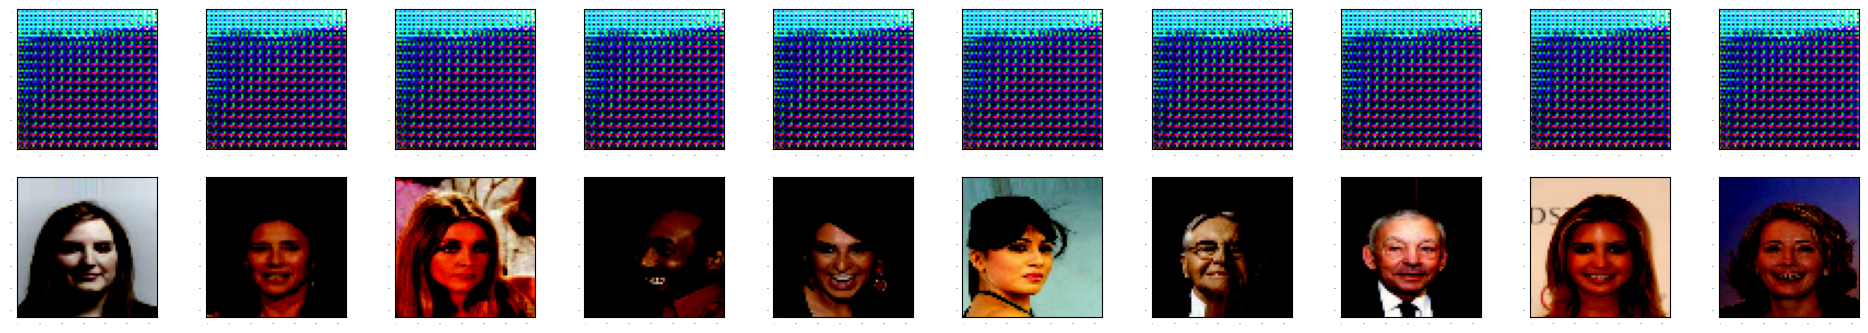

In [11]:
for _ in range(1):
    num_sample = 10
    pred = gen.predict(enc.predict(X_train[0])).reshape(-1, img_dim, img_dim, 3)

    _, axs = plt.subplots(2,num_sample, figsize=(24,4))
    for i in range(num_sample):
        img = np.clip((pred[i]+1)*(255.0/2), 0, 255).astype("uint32")
        axs[0][i].imshow(img)
        axs[0][i].tick_params(length=0, labelsize=0)
        
        axs[1][i].imshow(X_train[0][i])
        axs[1][i].tick_params(length=0, labelsize=0)

1/1 [==============================] - 0s 37ms/step


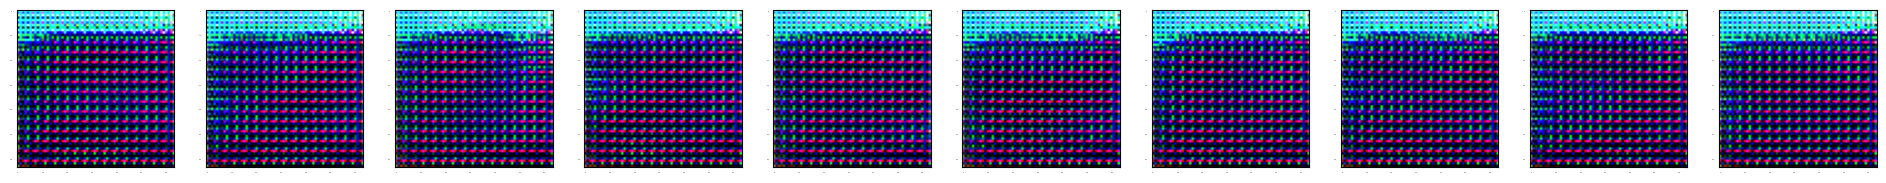

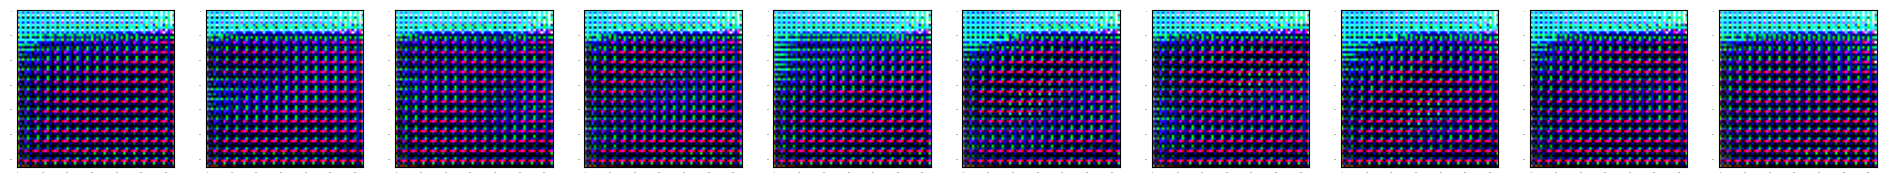

In [12]:
for _ in range(2):
    num_sample = 10
    z_test = np.random.normal(scale = 2, size = (num_sample, latent_dim)).astype("float32")
    pred = gen.predict(z_test[:num_sample]).reshape(-1, img_dim, img_dim, 3)

    _, axs = plt.subplots(1,num_sample, figsize=(24,4))
    for i in range(num_sample):
        img = np.clip((pred[i]+1)*(255.0/2), 0, 255).astype("uint32")
        axs[i].imshow(img)
        axs[i].tick_params(length=0, labelsize=0)